In [1]:
from mimic.utilities import *

from mimic.model_infer.infer_gLV_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Repeat Rutter & Dekker et al 2024 analysis

In [2]:
def get_data(input_data):
    # Read the CSV file
    d = pd.read_csv(input_data)
    
    # Calculate the mean of columns 2 to 5 (index 1 to 4) for each row
    # Take only time course up to t=400
    X1_bar = d.iloc[1:21, 1:5].mean(axis=1)
    
    # Calculate the mean of columns 6 to 9 (index 5 to 8) for each row
    X2_bar = d.iloc[1:21, 5:9].mean(axis=1)
    
    # Combine the first column with the calculated means
    obs = pd.DataFrame({
        'time': d.iloc[1:21, 0],
        'X1_bar': X1_bar,
        'X2_bar': X2_bar
    })
    
    # Replace negative values with 0
    obs[obs < 0] = 0
    
    return obs



def plot_growth_curves(data):
    plt.figure(figsize=(10, 6))
    
    # Plotting X1_bar
    plt.plot(data['time'], data['X1_bar'], label='X1_bar')
    
    # Plotting X2_bar
    plt.plot(data['time'], data['X2_bar'], label='X2_bar')
    
    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Growth Curves of X1_bar and X2_bar')
    
    # Adding a legend
    plt.legend()
    
    # Display the plot
    plt.show()
    
    

In [3]:
PM3_EntA_data = get_data('PM3-EntA-coculture.csv')

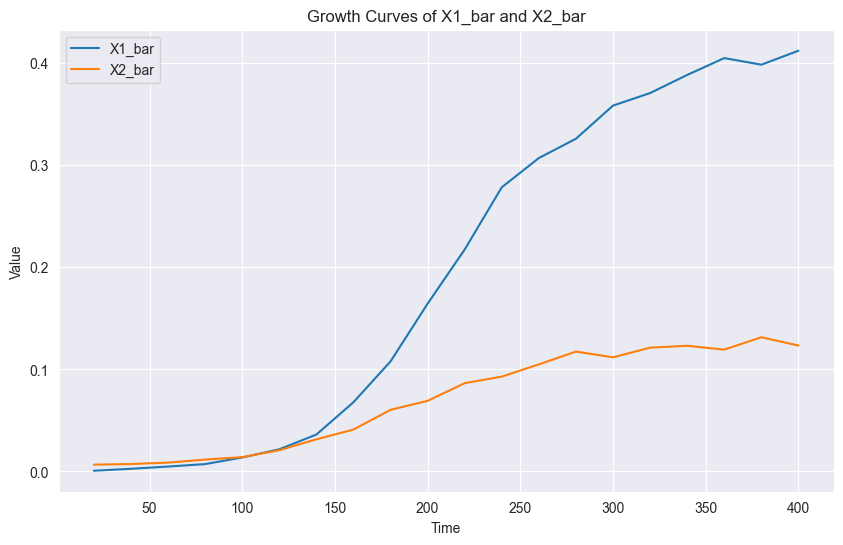

In [4]:
# Visualise the mean of the growth curves of both species grown in co-culture together
plot_growth_curves(PM3_EntA_data)

In [5]:
# Extract data and convert to numpyarrays

yobsdf = PM3_EntA_data.iloc[:, [1,2]]
yobs = yobsdf.to_numpy()
timesa = PM3_EntA_data.iloc[:, 0]
times = timesa.to_numpy()

In [6]:
print(yobs)

[[0.00072192 0.00665308]
 [0.00260168 0.00728166]
 [0.00481121 0.00865545]
 [0.00721984 0.0116635 ]
 [0.01367956 0.01402044]
 [0.02169891 0.02080109]
 [0.03614343 0.03148157]
 [0.06780534 0.04102799]
 [0.1078001  0.06039157]
 [0.16433957 0.06916043]
 [0.21739263 0.08649903]
 [0.27834507 0.0928716 ]
 [0.30699755 0.10491079]
 [0.325903   0.117422  ]
 [0.35835908 0.11179925]
 [0.37063256 0.12125911]
 [0.38838541 0.12308959]
 [0.40489237 0.11932429]
 [0.39841823 0.13147344]
 [0.41210938 0.12333229]]


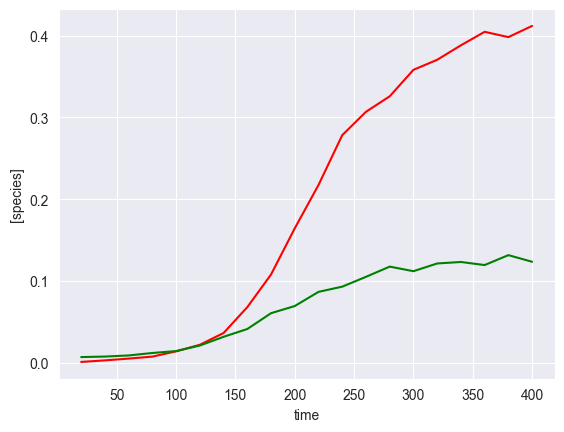

In [7]:
plot_gLV(yobs, times)

In [8]:
X, F = linearize_time_course_16S(yobs, times)
print(X.shape)
print(F)

(19, 3)
[[ 0.06410781  0.00451447]
 [ 0.030741    0.00864193]
 [ 0.02029504  0.01491441]
 [ 0.03195409  0.00920276]
 [ 0.02306859  0.01972501]
 [ 0.02551347  0.02072131]
 [ 0.031458    0.01324291]
 [ 0.02318223  0.01933004]
 [ 0.02108645  0.00678014]
 [ 0.01398885  0.01118549]
 [ 0.01235913  0.00355461]
 [ 0.00489876  0.00609444]
 [ 0.00298835  0.00563386]
 [ 0.00474679 -0.00245348]
 [ 0.00168398  0.00406172]
 [ 0.00233942  0.00074916]
 [ 0.00208133 -0.00155351]
 [-0.000806    0.0048483 ]
 [ 0.00168939 -0.00319625]]


In [9]:
# Define priors
#num_species = F.shape[1]


#mu_prior = np.array([0.03, 0.03])

mu_prior = [0.03, 0.03]

M_prior = 0.1

#M = np.zeros((num_species, num_species))
#np.fill_diagonal(M, [-0.2, -0.2])
#M[0, 1] = -0.1  # M12
#M[1, 0] = -0.2  # M21

In [10]:
# Perform Bayesian inference without shrinkage

inference = infergLVbayes(X, F, mu_prior, M_prior)
idata = inference.run_bayes_gLV_log_test()


X shape: (19, 3)
F shape: (19, 2)
Number of species: 2
Manually determined mu prior
Manually determined M prior
model mean before: [[0.11089612 0.37353987]
 [0.11099211 0.37352885]
 [0.11118705 0.37350478]
 [0.11159488 0.37345208]
 [0.11195021 0.37341079]
 [0.1128898  0.37329198]
 [0.11438396 0.37310485]
 [0.11586615 0.37293759]
 [0.11868306 0.37259832]
 [0.12025931 0.37244468]
 [0.1229165  0.3721409 ]
 [0.12421738 0.37202924]
 [0.12599839 0.37181831]
 [0.12776419 0.3715991 ]
 [0.12729096 0.37169762]
 [0.1286103  0.37153187]
 [0.12898588 0.3714998 ]
 [0.12862809 0.37156577]
 [0.13014854 0.37135291]]
log model mean after: [[-2.19916136 -0.98473054]
 [-2.19829615 -0.98476002]
 [-2.19654135 -0.98482446]
 [-2.19288006 -0.98496558]
 [-2.18970106 -0.98507616]
 [-2.18134318 -0.98539437]
 [-2.16819441 -0.9858958 ]
 [-2.1553196  -0.98634419]
 [-2.1312987  -0.98725432]
 [-2.11810499 -0.98766675]
 [-2.09625005 -0.98848274]
 [-2.08572219 -0.98878281]
 [-2.07148616 -0.98934996]
 [-2.05756894 -0.989

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'sigma_log__': array([0.95614633]), 'mu_hat_interval__': array([[ 0.90383543, -0.92171913]]), 'M_ii_hat_p_log__': array([-2.75314525, -2.49632864]), 'M_ij_hat': array([[-0.63063639],
       [ 0.14467241]])}

Logp initial evaluation results:
{'sigma': -1.38, 'mu_hat': -11.35, 'M_ii_hat_p': -1.64, 'M_ij_hat': -24.02, 'Y_obs': -inf}
You can call `model.debug()` for more details.

In [ ]:
#inference.plot_posterior_a(idata, mu_hat_np, M_hat_np)

In [ ]:
type(idata)
type(var_names)

In [11]:
# Print summary

summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                 mean     sd  r_hat
mu_hat[0, 0]    0.032  0.003   1.01
mu_hat[0, 1]    0.015  0.003   1.00
M_ii_hat[0]    -0.082  0.060   1.00
M_ii_hat[1]    -0.102  0.033   1.01
M_ij_hat[0, 0] -0.084  0.027   1.00
M_ij_hat[1, 0]  0.003  0.086   1.00
M_hat[0, 0]    -0.084  0.027   1.00
M_hat[0, 1]     0.000  0.000    NaN
M_hat[1, 0]     0.003  0.086   1.00
M_hat[1, 1]    -0.102  0.033   1.01
sigma[0]        0.007  0.001   1.00


'model_posterior.nc'

(2, 500, 2, 2)
(2, 500, 1, 2)
Using the following parameters for gLV simulation: {'num_species': 2, 'mu': array([0.03190893, 0.01462455]), 'M': array([[-0.08363076,  0.        ],
       [ 0.00225177, -0.10286186]]), 'epsilon': array([], shape=(2, 0), dtype=float64)}


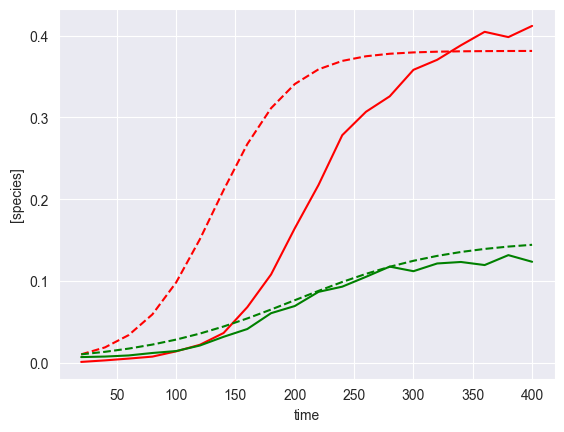

In [12]:
# Compare model parameters to the data
num_species = F.shape[1]
#init_species = 10 * np.ones(num_species)
init_species = 0.01 * np.ones(num_species)

print( idata.posterior["M_hat"].values.shape )

print( idata.posterior["mu_hat"].values.shape )

# # get median posterior values   
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1))

mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0, 1))
mu_h = mu_h.flatten()

#mu_h = idata.posterior['mu_hat'].mean(dim=('chain', 'draw')).values.flatten()
#M_h= idata.posterior['M_hat'].mean(dim=('chain', 'draw')).values

predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h
                 )
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)

plot_fit_gLV(yobs, yobs_h, times)
#compare_params(mu=(mu, mu_h), M=(M, M_h) )


## Perform Bayesian inference with shrinkage

In [ ]:
n_obs = times.shape[0] - 1
num_species = F.shape[1]
nX = num_species
noise_stddev = 0.1


# Params for shrinkage on M_ij (non diagonal elements)
DA = nX*nX - nX

#proportion = 3 / (5 * 4)  # Proportion for num_species = 5
#DA0 = int(proportion * num_species * (num_species - 1))

#DA0 = 3     # expected number of non zero entries in M_ij
N = n_obs - 2

In [ ]:
print(N)

In [ ]:
inference = infergLVbayes(X, F, DA=DA, N=N, noise_stddev=noise_stddev)
idata = inference.run_bayes_gLV_shrinkage()

In [ ]:
# Print summary

summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

In [ ]:
# Compare model parameters to the data
num_species = F.shape[1]
#init_species = 10 * np.ones(num_species)
init_species = 0.01 * np.ones(num_species)

print( idata.posterior["M_hat"].values.shape )

print( idata.posterior["mu_hat"].values.shape )

# # get median posterior values   
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1))

mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0, 1))
mu_h = mu_h.flatten()

#mu_h = idata.posterior['mu_hat'].mean(dim=('chain', 'draw')).values.flatten()
#M_h= idata.posterior['M_hat'].mean(dim=('chain', 'draw')).values

predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h
                 )
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)

plot_fit_gLV(yobs, yobs_h, times)
#compare_params(mu=(mu, mu_h), M=(M, M_h) )